# Preprocessing and registration
This notebook does basic preprocessing and registration for lightsheet data

Note v2 uses my saved data that was downsampled from imaris

version 3a contains downsampled data from imaris with origin and pixel set with metadata. It also has a fix where sampling was done on padded coordinates rather than unpadded

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from glob import glob
from os.path import join as pathjoin
import time

import sys
sys.path.append('..')
import imp
import donglab_workflows as dw
imp.reload(dw)


<module 'donglab_workflows' from '../donglab_workflows.py'>

In [2]:
# for now add emlddmm library for registration
import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
imp.reload(emlddmm)

<module 'emlddmm' from '/home/dtward/data/csh_data/emlddmm/emlddmm.py'>

In [3]:
# TODO: collect all input arguments in this cell
target_name = '/nafs/dtward/dong/final_output/SW220510_LS/SW220510_02_LS_6x_1000z_ch_0_pow_[0.125]_down.npz'
# where should outputs go?
output_prefix = 'lightsheet_outputs_2022_09_21/'
output_prefix = 'lightsheet_outputs_2023_02_16/'
# load atlas images
atlas_names = [
    '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_50.vtk',
    '/home/dtward/data/AllenInstitute/allen_vtk/average_template_50.vtk',
]
#seg_name = '/home/dtward/data/AllenInstitute/allen_vtk/annotation_50.vtk'
seg_name = '/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented.vtk'
seg_name = '/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
ontology_name = output_prefix + 'allen_ontology.csv'
ontology_name = '/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'
savename = 'transformation_outputs_lightsheet_v03newdownsample.npy'
device = 'cuda:1' # for pytorch

In [4]:
output_directory = os.path.split(output_prefix)[0]
if output_directory:
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

In [5]:
# load target image

In [6]:
target_data = np.load(target_name,allow_pickle=True)

In [7]:
def fix_shape(J,xJ):
    n = np.minimum(np.array(J.shape[1:]), np.array([len(x) for x in xJ]))
    J = J[:,:n[0],:n[1],:n[2]]
    xJ[-1] = xJ[-1][:n[-1]]
    xJ[-2] = xJ[-2][:n[-2]]
    xJ[-3] = xJ[-3][:n[-3]]
    
    return J,xJ


In [8]:
J = target_data['I'][None]
J = J.astype(np.float32)
J /= np.mean(np.abs(J))
xJ = target_data['xI']
dJ = [x[1] - x[0] for x in xJ]
J0 = np.copy(J)
if 'w' in target_data:
    W = target_data['w']
elif 'W' in target_data:
    W = target_data['W']
else:
    W = np.ones_like(J[0])
    # or actually
    W = (J[0]>0).astype(float)
W = (J[0]>0).astype(float)


J,xJ = fix_shape(J,xJ)
W,_ = fix_shape(W[None],xJ)
W = W[0]

In [9]:
emlddmm.draw(W[None])

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 15 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

<IPython.core.display.Javascript object>


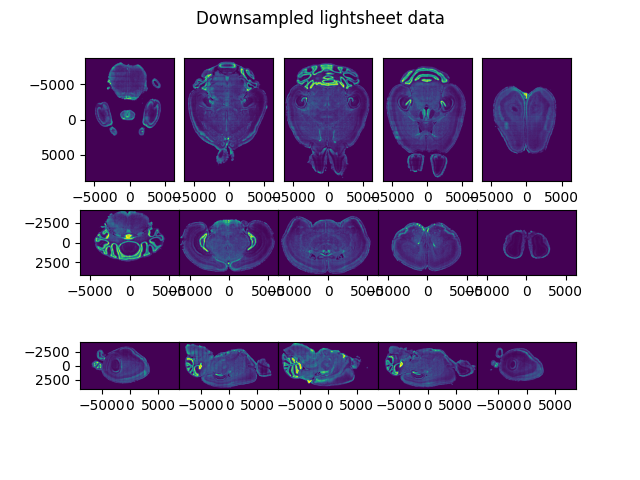

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  after removing the cwd from sys.path.


In [10]:
fig,ax = emlddmm.draw(J,xJ,vmin=np.min(J[W[None]>0.9]))
fig.suptitle('Downsampled lightsheet data')
figopts = {'dpi':300,'quality':90}
fig.savefig(output_prefix + 'downsampled.jpg',**figopts)
fig.canvas.draw()

In [11]:
I = []
for atlas_name in atlas_names:
    xI,I_,title,names = emlddmm.read_data(atlas_name)
    I_ = I_.astype(np.float32)
    I_ /= np.mean(np.abs(I_))
    I.append(I_)
    
I = np.concatenate(I)    
dI = [x[1] - x[0] for x in xI]
XI = np.meshgrid(*xI,indexing='ij')
I,xI = fix_shape(I,xI)

xI0 = [ np.copy(x)for x in xI]
I0 = np.copy(I)

<IPython.core.display.Javascript object>


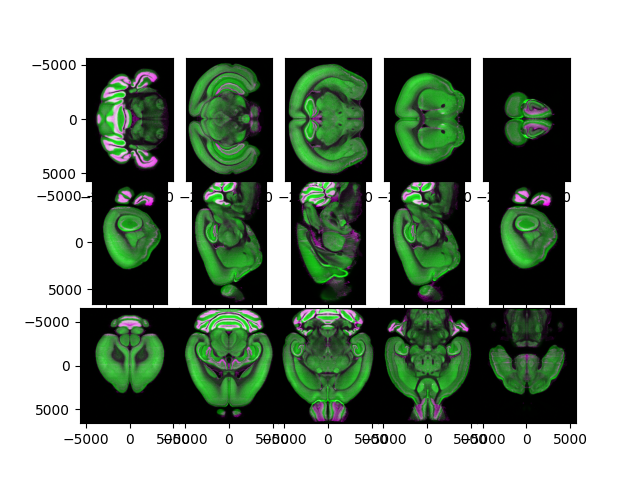

In [12]:
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

<IPython.core.display.Javascript object>


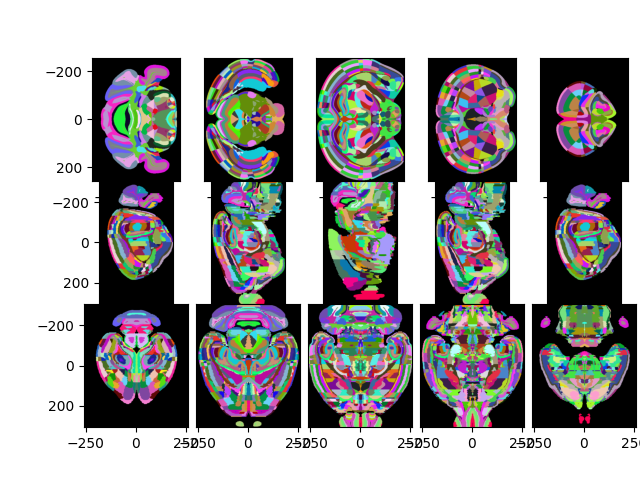

In [13]:
# next is to transforom the high resolution data
xS,S,title,names = emlddmm.read_data(seg_name)
# we want to visuze the above with S
labels,inds = np.unique(S,return_inverse=True)

colors = np.random.rand(len(labels),3)
colors[0] = 0.0

RGB = colors[inds].reshape(S.shape[1],S.shape[2],S.shape[3],3).transpose(-1,0,1,2)
#RGB = np.zeros((3,S.shape[1],S.shape[2],S.shape[3]))

#for i,l in enumerate(labels):
#    RGB[:,S[0]==l] = colors[i][...,None]
fig,ax = emlddmm.draw(RGB)
plt.subplots_adjust(wspace=0,hspace=0,right=1)
fig.canvas.draw()

In [14]:
# question, do they line up, given that they are different resolutions?
# FIXED
[x[1] - x[0] for x in xS]

[20.0, 20.0, 20.0]

# Initial preprocessing



## Target preprocessing

<IPython.core.display.Javascript object>


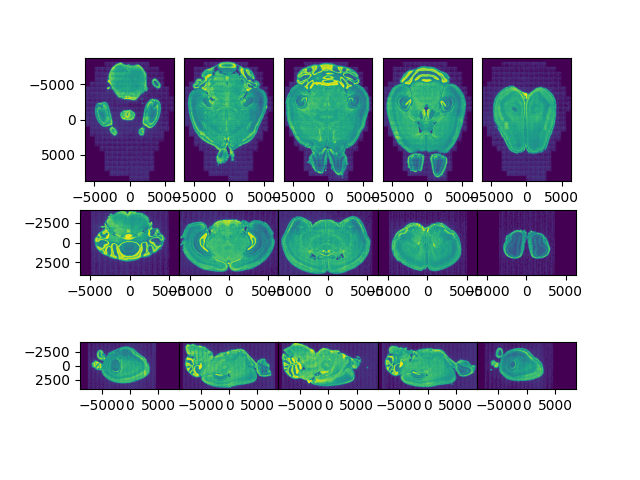

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


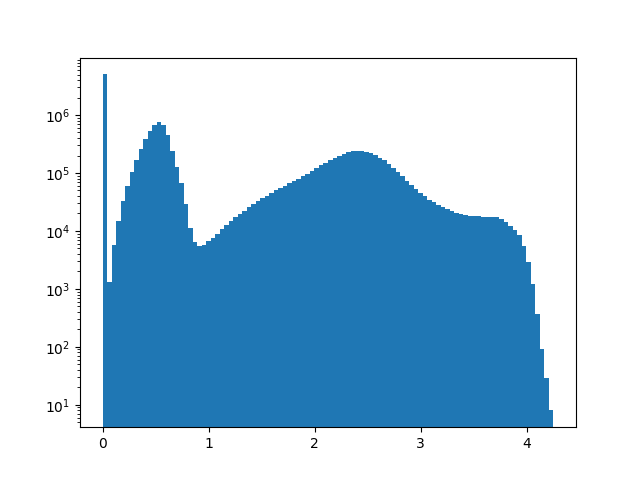

In [15]:
# background
J = J0 - np.quantile(J0[W[None]>0.9],0.1)
J[J<0] = 0
# adjust dynamic range
J = J**0.25

# adjust mean value
J /= np.mean(np.abs(J))
fig,ax = emlddmm.draw(J,xJ,vmin=0)
fig.canvas.draw()
fig.suptitle('Preprocessed lightsheet data')
fig.savefig(output_prefix + 'processed.jpg',**figopts)


fig,ax = plt.subplots()
ax.hist(J.ravel(),100,log=True)
fig.canvas.draw()

## Atlas preprocessing


In [16]:
# pad
# since I will downsample by 4, I want to pad with 4x4x4
npad = 4
I = np.pad(I0,  ((0,0),(npad,npad),(npad,npad),(npad,npad)) )
for i in range(npad):
    xI = [ np.concatenate(   (x[0][None]-d,x,x[-1][None]+d)   ) for d,x in zip(dI,xI0)]


In [17]:
# adjust nissl image dynamic range
I[0] = I[0]**0.5
I[0] /= np.mean(np.abs(I[0]))
I[1] /= np.mean(np.abs(I[1]))

<IPython.core.display.Javascript object>


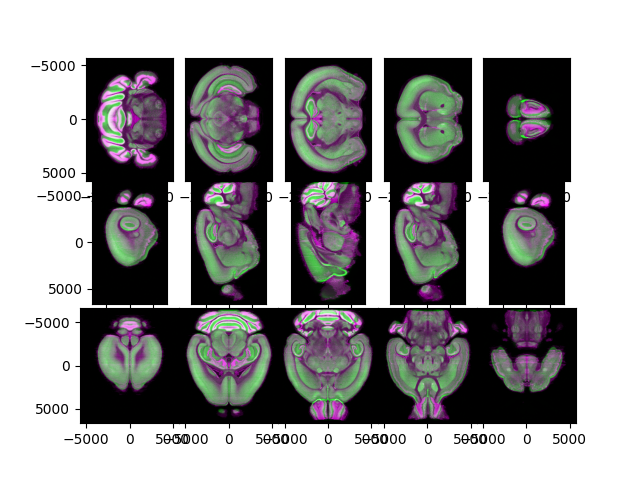

In [18]:
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

# Registration

/home/dtward/data/csh_data/emlddmm/emlddmm.py:2657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X = torch.as_tensor(X,dtype=self.data.dtype,device=self.data.device)


<IPython.core.display.Javascript object>


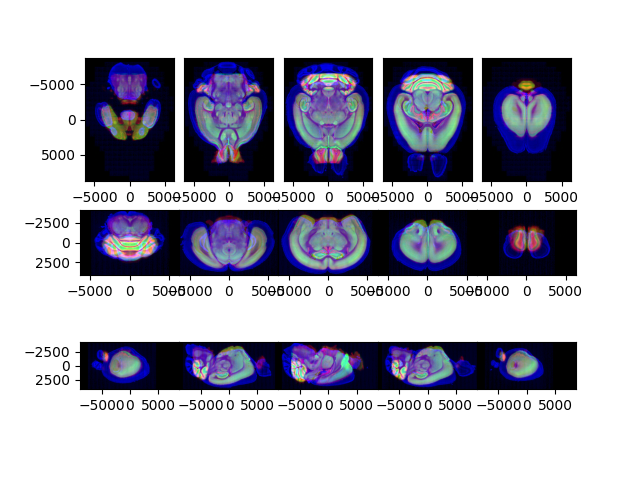

In [19]:
# initial affine
A0 = np.eye(4)
# make sure to keep sign of Jacobian
#A0 = np.diag((1.3,1.3,1.3,1.0))@A0
# flip x0,x1
A0 = np.array([[0.0,-1.0,0.0,0.0],[1.0,0.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip x0,x2
A0 = np.array([[0.0,0.0,-1.0,0.0],[0.0,1.0,0.0,0.0],[1.0,0.0,0.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip x1,x2
#A0 = np.array([[-1.0,0.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,1.0,0.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip 
#A0 = np.diag((1.0,-1.0,-1.0,1.0))@A0
# shift
#A0[0,-1] = +3500 # left right, positive will cut off the missing hemisphere as appropriate
#A0[1,-1] = -2500 # AP, negative will cut off the nose
#A0[2,-1] = -1000 # SI, negative will move the venttral surface toward the boundary

XJ = np.meshgrid(*xJ,indexing='ij')
A0[:3,-1] = np.mean(XJ,axis=(-1,-2,-3))

# check it
tform = emlddmm.Transform(A0,direction='b')
AI = emlddmm.apply_transform_float(xI,I,tform.apply(XJ))
fig,ax = emlddmm.draw(np.concatenate((AI[:2],J)),xJ,vmin=0)
fig.canvas.draw()


<IPython.core.display.Javascript object>


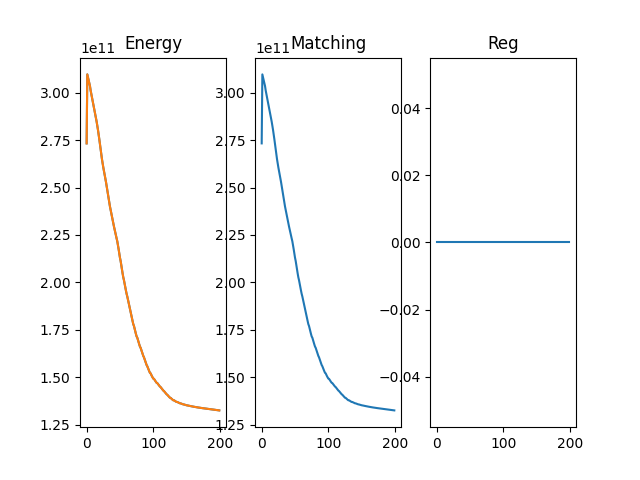

<IPython.core.display.Javascript object>


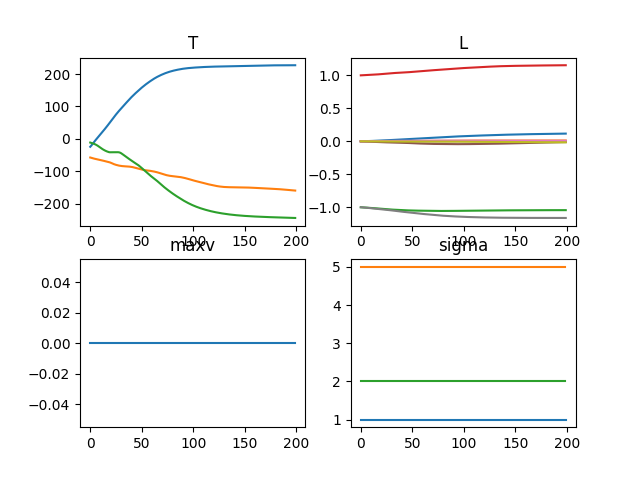

<IPython.core.display.Javascript object>


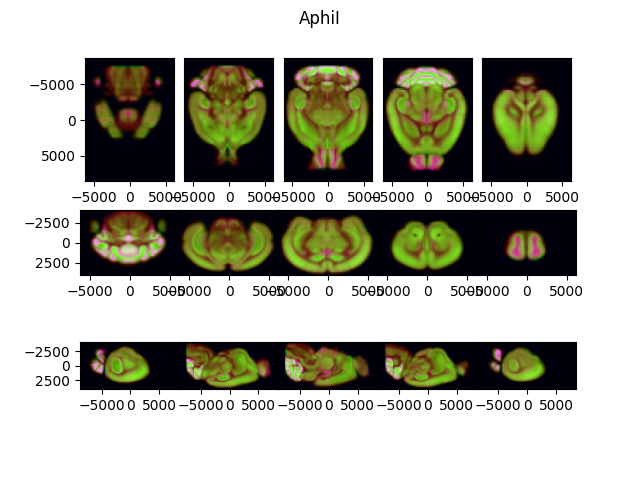

<IPython.core.display.Javascript object>


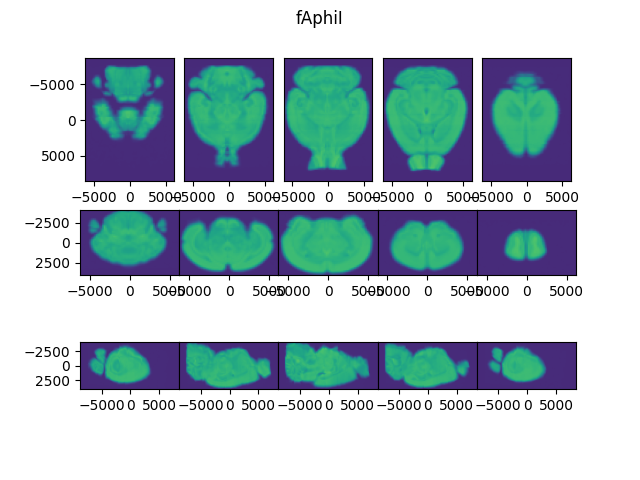

<IPython.core.display.Javascript object>


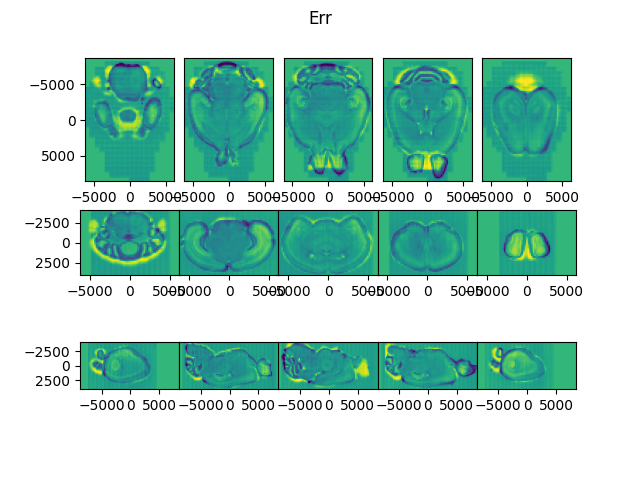

<IPython.core.display.Javascript object>


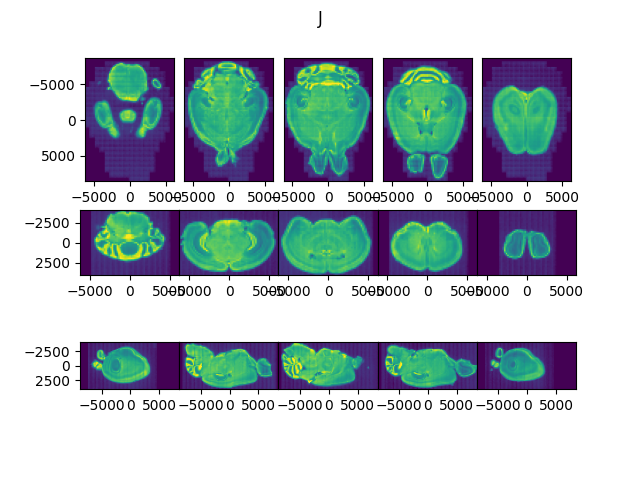

<IPython.core.display.Javascript object>


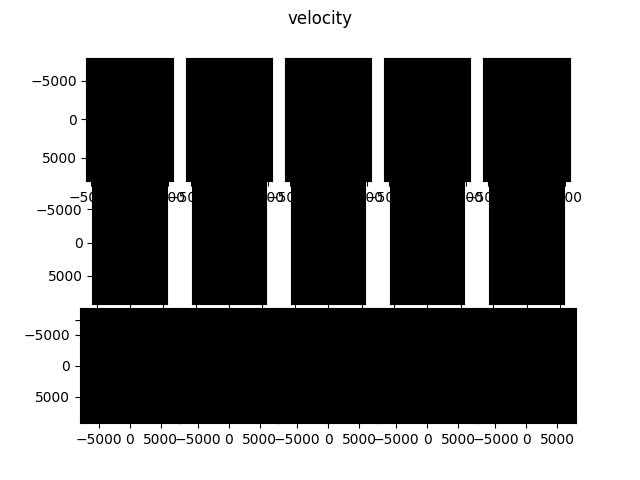

<IPython.core.display.Javascript object>


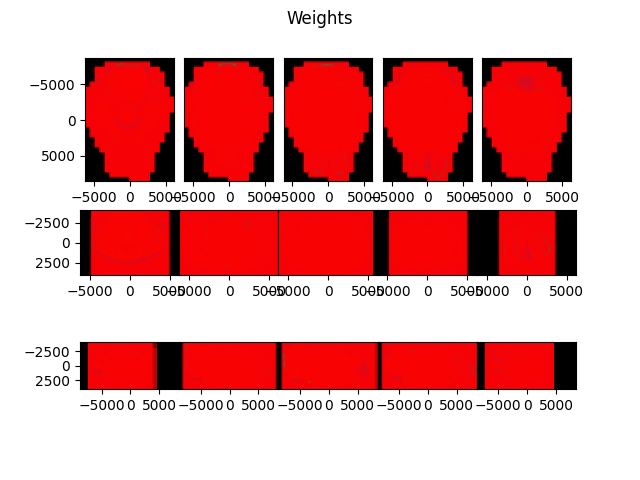

/home/dtward/data/csh_data/emlddmm/emlddmm.py:100: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


In [20]:
# now we want to register
config0 = {
    'device':device,
    'n_iter':200, 'downI':[4,4,4], 'downJ':[4,4,4],
     'priors':[0.9,0.05,0.05],'update_priors':False,
     'update_muA':0,'muA':[np.quantile(J,0.99)],
     'update_muB':0,'muB':[0.0],
     'update_sigmaM':0,'update_sigmaA':0,'update_sigmaB':0,
     'sigmaM':0.25,'sigmaB':0.5,'sigmaA':1.25,
     'order':1,'n_draw':50,'n_estep':3,'slice_matching':0,'v_start':1000,
     'eA':5e4,'A':A0,'full_outputs':True,
   }
# update my sigmas (august 22)
config0['sigmaM'] = 1.0
config0['sigmaB'] = 2.0
config0['sigmaA'] = 5.0
#W = np.ones_like(J[0])
#W = 1.0 - (J[0]==0)
#I_ = np.stack((I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2,))
#I_ = np.stack((I[2],I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2))
#I_ = np.stack((I[0],I[1],I[0]*I[1],I[0]**2,I[1]**2)) # I don't need I[2]
I_ = np.stack((I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
               (I[0]-np.mean(I[0]))**2,
               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
               (I[1]-np.mean(I[0]))**2,))

out = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config0)

<IPython.core.display.Javascript object>


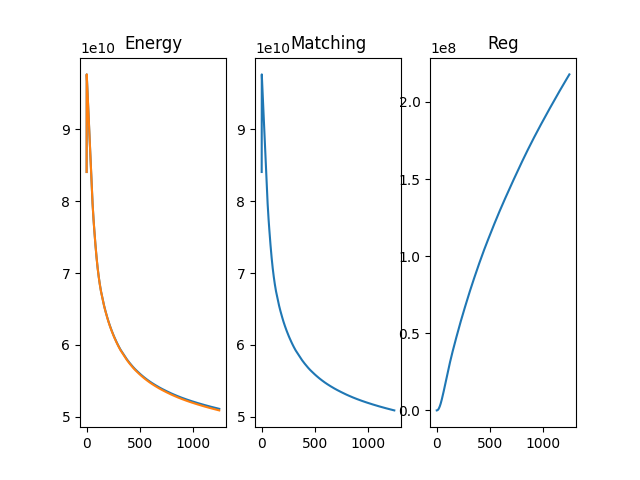

<IPython.core.display.Javascript object>


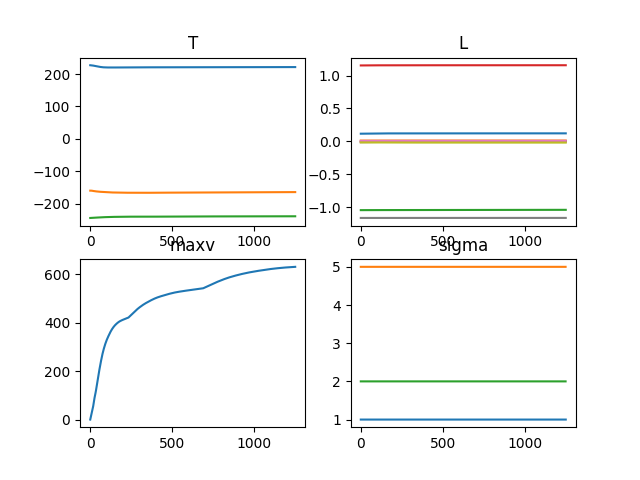

<IPython.core.display.Javascript object>


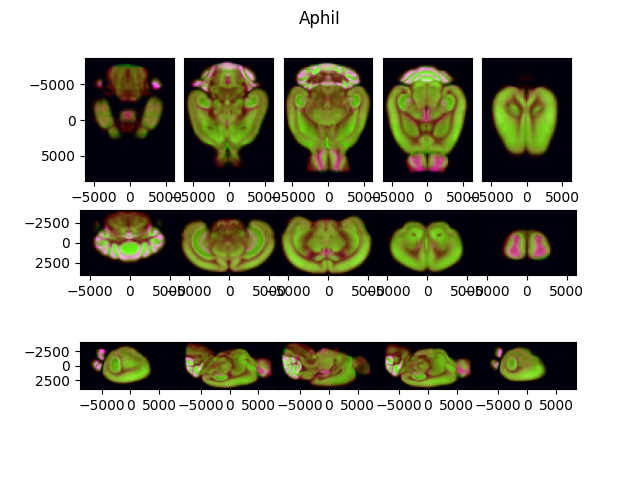

<IPython.core.display.Javascript object>


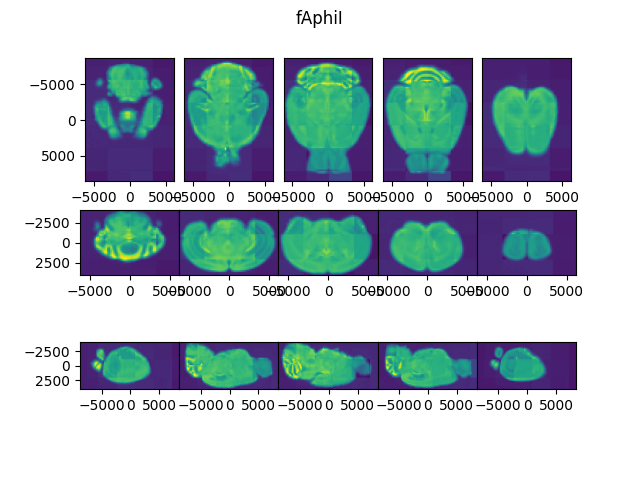

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1075: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figErr = plt.figure()


<IPython.core.display.Javascript object>


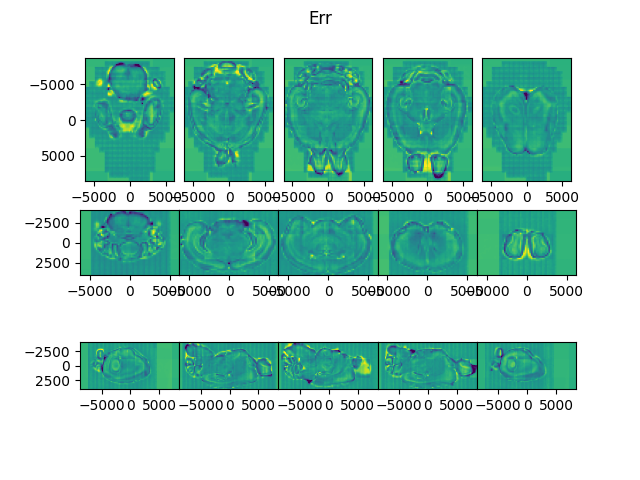

<IPython.core.display.Javascript object>


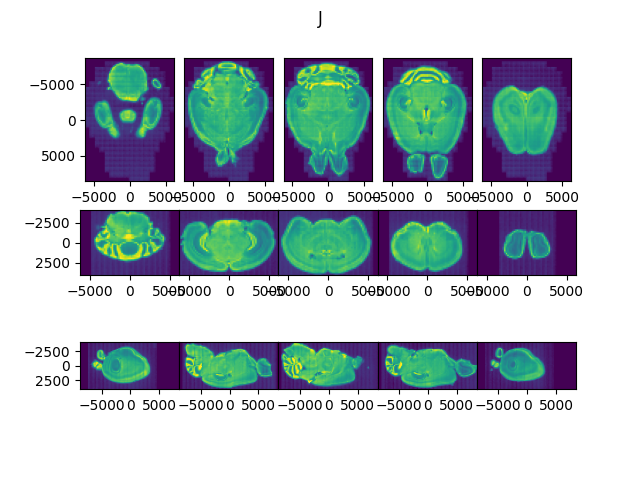

<IPython.core.display.Javascript object>


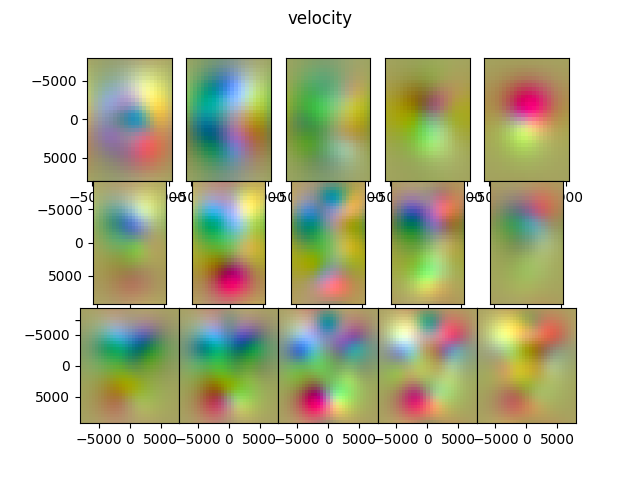

<IPython.core.display.Javascript object>


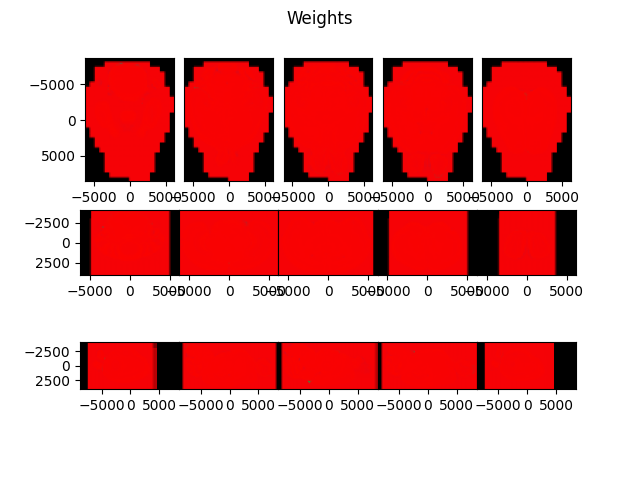

Iteration 80, linear oscilating, reducing eA to 4500.0
Iteration 270, linear oscilating, reducing eA to 4050.0
Iteration 290, translation oscilating, reducing eA to 3645.0
Iteration 620, linear oscilating, reducing eA to 3280.5
Iteration 1110, linear oscilating, reducing eA to 2952.4500000000003


In [ ]:
# second run, with deformation
config1 = dict(config0)
config1['A'] = out['A']
config1['eA'] = config0['eA']*0.1
config1['a'] = 1000.0
config1['sigmaR'] = 5e4 # 1e4 gave really good results, but try 2e4, also good, I showed this in my slides
config1['n_iter']= 2000
config1['v_start'] = 0
config1['ev'] = 1e-2
config1['ev'] = 2e-3 # reduce since I decreased sigma
config1['v_res_factor'] = config1['a']/dI[0]/2 # what is the resolution of v, as a multiple of that in I
config1['local_contrast'] = [32,32,32]
config1['local_contrast'] = [16,16,16]
#config1['device'] = config0['device']

#I_ = np.stack((I[2],I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2,))

# note this approach has an issue with background being black
#I_ = np.stack((I[2],I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
#               (I[0]-np.mean(I[0]))**2,
#               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
#               (I[1]-np.mean(I[0]))**2,))
I_ = np.stack((I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
               (I[0]-np.mean(I[0]))**2,
               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
               (I[1]-np.mean(I[0]))**2,))


out1 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config1)

In [ ]:
imp.reload(emlddmm)
# on the next run we do les downsampling
config2 = dict(config1)
config2['A'] = out1['A']
config2['n_iter']= 1000
config2['v'] = out1['v']
config2['downI'] = [2,2,2]
config2['downJ'] = [2,2,2]
# there seems to be an issue with the initial velocity
# when I run this twice, I'm reusing it
out2 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config2)
# the matching energy here is way way lower, why would that be?

In [ ]:
# save the outputs
np.save(output_prefix+savename,np.array([out2],dtype=object))

In [ ]:
out2['figI'].savefig(output_prefix + 'transformed.jpg',**figopts)
out2['figfI'].savefig(output_prefix + 'contrast.jpg',**figopts)
out2['figErr'].savefig(output_prefix + 'err.jpg',**figopts)

In [ ]:
fig = out2['figErr']
axs = fig.get_axes()
for ax in axs:
    ims = ax.get_images()
    for im in ims:
        im.set_cmap('twilight')
        clim = im.get_clim()
        lim = np.max(np.abs(clim))
        im.set_clim(np.array((-1,1))*lim)
fig.canvas.draw()
fig.savefig(output_prefix + 'err.jpg',**figopts)

# Prepare some visualizations

In [ ]:
# compute transform for atlas and labels
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='b')
affine = emlddmm.Transform(out2['A'],direction='b')
tform = emlddmm.compose_sequence([affine,deformation],XJ)

In [ ]:
# transform the atlas and labels, notice different domains
It = emlddmm.apply_transform_float(xI,I,tform).cpu().numpy()
RGBt = emlddmm.apply_transform_float(xS,RGB,tform).cpu().numpy()
St = emlddmm.apply_transform_int(xS,S,tform,double=True,padding_mode='zeros').cpu().numpy()

In [ ]:
#fig,ax = emlddmm.draw(np.stack((It[0]*0.5,It[1]*0.5,Jsave[0]*1.5)),xJ,vmin=0,vmax=4)
#fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig,ax = emlddmm.draw(np.stack((It[0]*0.5,It[1]*0.5,J0[0]*1.5)),xJ,)
fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'IJsave.jpg')

In [ ]:
fig,ax = emlddmm.draw(It,xJ)
fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'Isave.jpg')

In [ ]:
fig,ax = emlddmm.draw(J,xJ)
plt.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'Jsave.jpg')

In [ ]:
# transform the target to atlas
# for visualizatoin, we want to sample at xS so we can view it relative to the
XS = np.stack(np.meshgrid(*xS,indexing='ij'))
imp.reload(emlddmm)
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='f')
affine = emlddmm.Transform(out2['A'],direction='f')
tformi = emlddmm.compose_sequence([deformation,affine,],XS)
#J_ = J0**0.25
J_ = np.copy(J)
Jt = emlddmm.apply_transform_float(xJ,J_,tformi,padding_mode='zeros').cpu().numpy()

In [ ]:
# view the transformed target
fig,ax = emlddmm.draw(Jt,xS,vmin=np.quantile(J_,0.02),vmax=np.quantile(J_,0.98))
fig.subplots_adjust(wspace=0,hspace=0,right=1)

In [ ]:
# view the transformed target with labels
minval = 1.5
maxval = 2.9
minval = 0.0
maxval = 5.0
alpha = 0.3
alpha = 0.75
fig = plt.figure(figsize=(7,7))
n = 4
slices = np.round(np.linspace(0,I.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGB[:,slices[i]].transpose(1,2,0)
    S_ = S[0,slices[i]]
    Jt_ = np.copy(Jt[0,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,I.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGB[:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,I.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGB[:,:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Atlas space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
fig.savefig(output_prefix+'atlas_space.jpg',**figopts)

In [ ]:
# view the transformed labels with the target
fig = plt.figure(figsize=(8,5))
slices = np.round(np.linspace(0,J.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGBt[:,slices[i]].transpose(1,2,0)
    S_ = St[0,slices[i]]
    Jt_ = np.copy(J[0,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,J.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGBt[:,:,slices[i]].transpose(1,2,0)
    S_ = St[0,:,slices[i]]
    Jt_ = np.copy(J[0,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,J.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGBt[:,:,:,slices[i]].transpose(1,2,0)
    S_ = St[0,:,:,slices[i]]
    Jt_ = np.copy(J[0,:,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Target space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
fig.savefig(output_prefix+'target_space.jpg',**figopts)

# Get bounding boxes for striatum or another structure

In [ ]:
import requests,csv

In [ ]:
# don't do this because we wlil use Yongsoo ontology
'''
# bounding boxes using St
ontology_name = output_prefix + 'allen_ontology.csv'
r = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,\
rma::criteria,[ontology_id$eq1],\
rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]\
'
if True:# not os.path.exists(ontology_name):
    output = requests.get(r)
    with open(ontology_name,'wt') as f:
        f.write(output.text)
'''        

In [ ]:
parent_column = 7 # 8 for allen, 7 for yongsoo
label_column = 0 # 0 for both
shortname_column = 2# 3 for allen, 2 for yongsoo
longname_column = 1# 2 for allen, 1 for yongsoo
ontology = dict()
with open(ontology_name) as f:
    csvreader = csv.reader(f, delimiter=',', quotechar='"')
    count = 0
    for row in csvreader:        
        if count == 0:
            headers = row
            print(headers)
        else:
            if not row[parent_column]:
                parent = -1
            else:
                parent = int(row[parent_column])
            ontology[int(row[label_column])] = (row[shortname_column],row[longname_column],parent)
        count += 1


In [ ]:
ontology

In [ ]:
# we need to find all the descendants of a given label
# first we'll get children
children = dict()
for o in ontology:
    parent = ontology[o][-1]
    if parent not in children:
        children[parent] = []
    children[parent].append(o)

In [ ]:
# now we go from children to descendents
descendents = dict(children)
for o in descendents:
    for child in descendents[o]:
        if child in descendents: # if I don't do this i get a key error 0
            descendents[o].extend(descendents[child])
descendents[0] = []

In [ ]:
descendents_and_self = dict(descendents)
for o in descendents_and_self:
    descendents_and_self[o].append(o)

In [ ]:
# or we could just loop through
labels = np.unique(St)
bbox = dict()
for l in labels:
    # skip background
    if l == 0:
        continue
    
    Sl = St == l
    
    # include all the descendents
    for o in descendents_and_self[l]:
        Sl = np.logical_or(Sl,St==o)
    
    
    bbox2 = xJ[2][np.nonzero(np.sum(Sl,(0,1,2))>0)[0][[0,-1]]]
    bbox1 = xJ[1][np.nonzero(np.sum(Sl,(0,1,3))>0)[0][[0,-1]]]
    bbox0 = xJ[0][np.nonzero(np.sum(Sl,(0,2,3))>0)[0][[0,-1]]]
    bbox[l] = (bbox2[0],bbox2[1],bbox1[0],bbox1[1],bbox0[0],bbox0[1],ontology[l][0],ontology[l][1])
    


In [ ]:
asdf

In [ ]:
import pandas as pd
df = pd.DataFrame(bbox).T
bbox_headings = ('x0','x1','y0','y1','z0','z1','short name','long name')
df.columns=bbox_headings
df.index.name = 'id'

In [ ]:
df

In [ ]:
df.to_csv(output_prefix + 'bboxes.csv')

In [ ]:
# TODO, separate left from right in bounding box

In [ ]:
# TODO, use a surface instead of bounding box. use marching cubes. figure out file format.

In [ ]:
# see link on slack vrml (wireframe objects9-)

In [ ]:
def compute_face_normals(verts,faces,normalize=False):
    e1 = verts[faces[:,1]] - verts[faces[:,0]]
    e2 = verts[faces[:,2]] - verts[faces[:,1]]
    n = np.cross(e1,e2)/2.0
    if normalize:
        n /= np.sqrt(np.sum(n**2,1,keepdims=True))
        pass
    return n

In [ ]:
# TODO for daniel, write out surfaces that are parent and all the descendents (february 15)

In [ ]:
# let's get marching cubes surfaces going
oJ = [x[0] for x in xJ]
from skimage.measure import marching_cubes
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# or we could just loop through
labels = np.unique(St)
bbox = dict()

#verts0,faces0,normals0,values0 = marching_cubes((St[0]>0)*1.0,level=0.5,spacing=dJ)


fig = plt.figure()

for l in labels:
    # skip background
    if l == 0:
        continue
    
    Sl = St == l
    # do marching cubes
    
    verts,faces,normals,values = marching_cubes(Sl[0]*1.0,level=0.5,spacing=dJ)
    # deal with the offsets
    verts += oJ
    
    # let's save this
    readme = 'Data are saved in ZYX order'
    np.savez(output_prefix + f'structure_{l:012d}_surface.npz',verts=verts,faces=faces,normals=normals,values=values,readme=readme)
    
    surf = Poly3DCollection(verts[faces])
    n = compute_face_normals(verts,faces,normalize=True)
    surf.set_color(n*0.5+0.5)
    fig.clf()
    ax = fig.add_subplot(projection='3d')
    ax.add_collection3d(surf)
    xlim = (np.min(verts[:,0]),np.max(verts[:,0]))
    ylim = (np.min(verts[:,1]),np.max(verts[:,1]))
    zlim = (np.min(verts[:,2]),np.max(verts[:,2]))
    # fix aspect ratio
    r = [np.diff(x) for x in (xlim,ylim,zlim)]
    rmax = np.max(r)
    c = [np.mean(x) for x in (xlim,ylim,zlim)]
    xlim = (c[0]-rmax/2,c[0]+rmax/2)
    ylim = (c[1]-rmax/2,c[1]+rmax/2)
    zlim = (c[2]-rmax/2,c[2]+rmax/2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    
    ax.set_title(f'structure {l}, {ontology[l][1]} ({ontology[l][0]})')    
    fig.canvas.draw()
    fig.savefig(output_prefix + f'structure_{l:012d}_surface.jpg')
    
    


# Map neurons
We will want to use these maps to apply to swc files

/qnap/3D_stitched_LS/20220725_SW220510_02_LS_6x_1000z/Ex_488_Em_525_Terafly_Ano/recut/run-13_model_base_rf_17_55_57_19_23_19/sort/Maybe_structures/structure_000000000981_surface

note that this probably should be done AFTER registration, not during, since the swc files may not be ready yet.

Let's use good structures instead of maybe structures.